In [1]:
import scipy.io
data = scipy.io.loadmat('exp/datasets/Besson_Data/rf_image_invivo.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'G_param', 'rf_image'])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
import scipy.io

# Load the data
data = scipy.io.loadmat('exp/datasets/Besson_Data/rf_image_invivo.mat')
rf = data['rf_image'].astype(np.float64)
print('RF shape:', rf.shape)
print('RF range: min =', np.min(rf), ', max =', np.max(rf))

RF shape: (1228, 382)
RF range: min = -1418.911998438411 , max = 1411.0832784309375


In [3]:
# Load the estimated PSF from the uploaded psf.mat file
psf_mat_path = 'exp/datasets/Besson_Data/psf_besson_oleg.mat'
psf_data = scipy.io.loadmat(psf_mat_path)

# List keys to identify the PSF variable
psf_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'cropped_psf'])

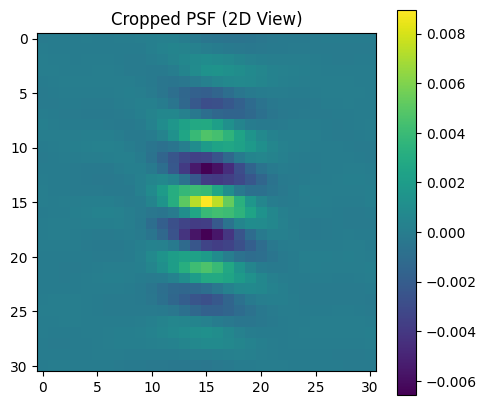

In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the cropped PSF from the uploaded .mat file
mat = scipy.io.loadmat('exp/datasets/Besson_Data/psf_besson_oleg.mat')
cropped_psf = mat['cropped_psf']

# Plot the 2D image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(cropped_psf, cmap='viridis')
plt.title('Cropped PSF (2D View)')
plt.axis('image')
plt.colorbar()


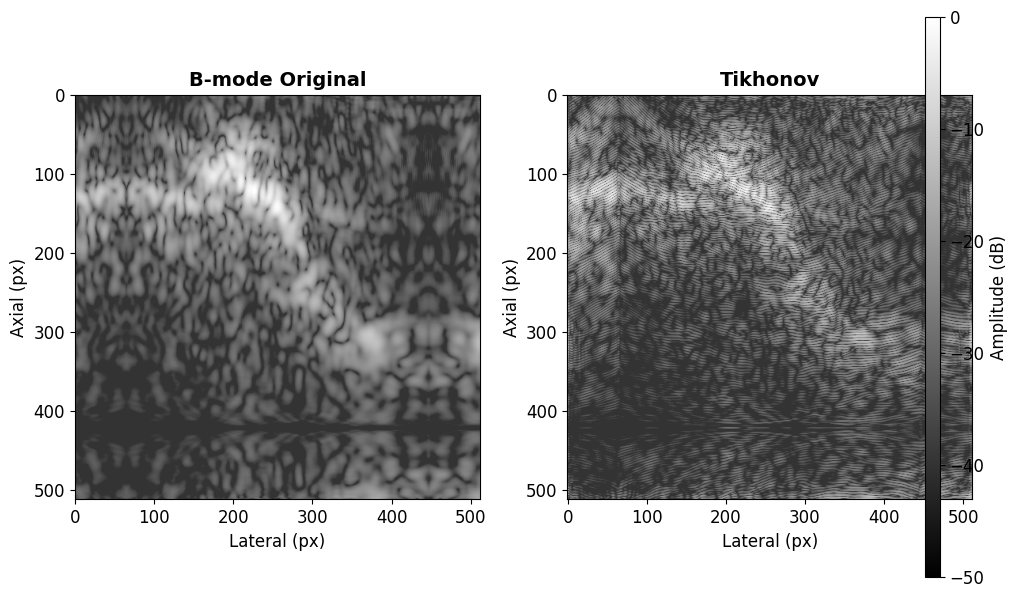

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert, correlate
import warnings
warnings.filterwarnings('ignore')

# 1. Load raw RF data
data = loadmat('exp/datasets/Besson_Data/besson_data3.mat')
#rf = data['rf_image']
rf = data['data']
rfn = rf / np.max(np.abs(rf))  # normalized RF

# 2. Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/Besson_Data/psf_besson_oleg.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))
Mh, Nh = H.shape
center = np.round(np.array([Mh, Nh])/2).astype(int)

pad_h = np.pad(h, ((0, rf.shape[0]-Mh), (0, rf.shape[1]-Nh)), mode='constant')
pad_h = np.roll(pad_h, 1-center[0], axis=0)
pad_h = np.roll(pad_h, 1-center[1], axis=1)

D = np.fft.fft2(pad_h)
SNR_val = 500  # ~60 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (SNR_val**(-1) + np.conj(D)*D)).real

# 3. Envelope detection and log compression
M, N = rf.shape
rf = rf[:M, :N]
VivoTK = VivoTK[:M, :N]

# Raw data processing
env_raw = np.abs(hilbert(rf, axis=0))
env_raw = env_raw / np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)
bmode_raw = np.maximum(bmode_raw, -40)

# Tikhonov processing
env_tikh = np.abs(VivoTK)
env_tikh = env_tikh / np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)
bmode_tikh = np.maximum(bmode_tikh, -40)



# 5. Visualization
fig = plt.figure(figsize=(10, 8))
fig.canvas.manager.set_window_title('B-mode Comparison')

titles = ['B-mode Original', 'Tikhonov']
images = [bmode_raw, bmode_tikh]

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=-50, vmax=0, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Lateral (px)', fontsize=12)
    ax.set_ylabel('Axial (px)', fontsize=12)
    ax.tick_params(labelsize=12)

plt.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Amplitude (dB)', fontsize=12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()


In [8]:
from scipy.io import savemat
savemat('exp/datasets/Besson_Data/Besson_Tikhonov.mat', {'VivoTK': VivoTK})


In [9]:
# Save the figure
output_path = "exp/image_samples/All_Results_png/Besson_Tikhonov.png"
fig.savefig(output_path, dpi=300, bbox_inches='tight')

### DDRM

In [57]:
folder_name = "Besson/P1_it20sigma20"

In [58]:
!python main.py --ni --config deblur_besson.yml --doc imagenet_ood --timesteps 20 --eta 0.85 --etaB 1 --deg deblur_bccb --sigma_0 20 -i {folder_name}

Module path: /projects/minds/PDAS-M2-2025/DDPM
Current sys.path: ['/projects/minds/PDAS-M2-2025/Stable_DDRM', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '/home/pdas/.local/lib/python3.10/site-packages', '/usr/local/lib/python3.10/dist-packages', '/usr/local/lib/python3.10/dist-packages/nvfuser-0.1.4a0+d0bb811-py3.10-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/projects/minds/PDAS-M2-2025/DDPM']
File not found: /projects/minds/PDAS-M2-2025/DDPM/denoising_diffusion_pytorch.py
Import failed: No module named 'denoising_diffusion_pytorch'
INFO - main.py - 2025-08-29 22:23:43,806 - Using device: cuda
INFO - main.py - 2025-08-29 22:23:43,807 - Writing log file to exp/logs/imagenet_ood
INFO - main.py - 2025-08-29 22:23:43,807 - Exp instance id = 996243
INFO - main.py - 2025-08-29 22:23:43,807 - Exp comment = 
building dataset from exp/BessonData.txt
read meta done
Start from 0
  0%|                                                     | 0/1 [00

RF raw range:       min = -0.9620, max = 1.0000
Tikhonov range:     min = -1.0000, max = 0.9687
DDRM range:         min = -1.0000, max = 0.9486
Saved combined PDF: exp/image_samples/Besson/P1_it20sigma20/Bmode_Comparison.pdf
Saved single-panel PDFs to: exp/image_samples/Besson/P1_it20sigma20


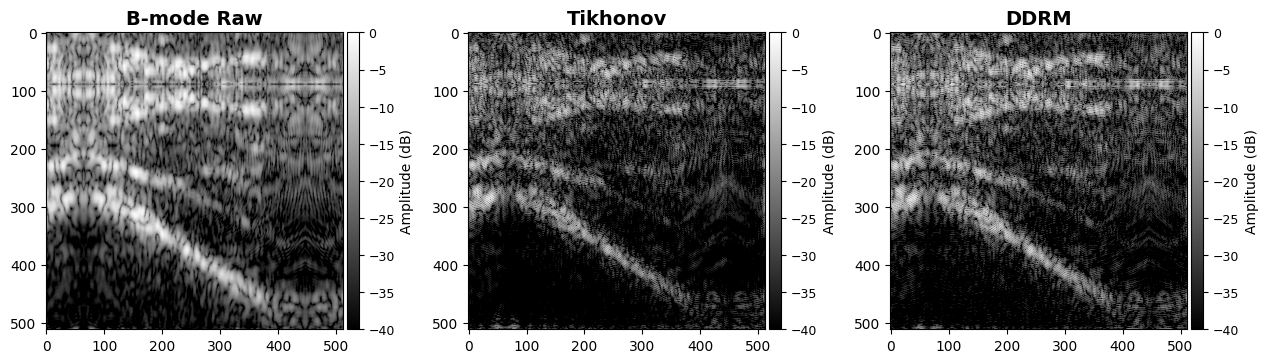

In [59]:


# ========= PROCESS & SAVE PLOTS =========
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1) Load raw RF data
data = loadmat('exp/datasets/Besson_Data/besson_data1.mat')
rf = data['data']
rfn = rf / np.max(np.abs(rf))  # Normalize RF

# 2) Tikhonov restoration (Wiener filter)
psf_data = loadmat('exp/datasets/Besson_Data/psf_besson_oleg.mat')
H = psf_data['cropped_psf']
h = H / np.sum(np.abs(H))

Mh, Nh = h.shape
Mrf, Nrf = rf.shape
center = np.round([Mh, Nh]) / 2

# Create BCCB degradation operator
pad_h = np.pad(h, ((0, Mrf - Mh), (0, Nrf - Nh)), mode='constant')
pad_h = np.roll(pad_h, int(1 - center[0]), axis=0)
pad_h = np.roll(pad_h, int(1 - center[1]), axis=1)
D = np.fft.fft2(pad_h)

SNR_val = 500  # ~30 dB
VivoTK = np.fft.ifft2(np.fft.fft2(rfn) * np.conj(D) / (1/SNR_val + np.conj(D)*D))
VivoTK = np.real(VivoTK)
VivoTK /= np.max(np.abs(VivoTK))

# 3) DDRM restoration (auto-load from the same run folder)
base_dir = Path("exp/image_samples") / folder_name
base_dir.mkdir(parents=True, exist_ok=True)
ddrm_data = loadmat(base_dir / "0_-1.mat")
image = ddrm_data['image']
if image.ndim == 3:
    image = np.transpose(image, (1, 2, 0))
grayimage = np.mean(image, axis=2) if image.ndim == 3 else image
grayimage = grayimage / np.max(np.abs(grayimage))  # Normalize



# Envelope + Log Compression
env_raw = np.abs(hilbert(rf, axis=0));     env_raw /= np.max(env_raw)
env_tikh = np.abs(VivoTK);                 env_tikh /= np.max(env_tikh)
env_ddrm = np.abs(grayimage);              env_ddrm /= np.max(env_ddrm)

bmode_raw  = 20 * np.log10(env_raw  + np.finfo(float).eps)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)
bmode_ddrm = 20 * np.log10(env_ddrm + np.finfo(float).eps)

# 5) Print statistics
print(f'RF raw range:       min = {np.min(rfn):.4f}, max = {np.max(rfn):.4f}')
print(f'Tikhonov range:     min = {np.min(VivoTK):.4f}, max = {np.max(VivoTK):.4f}')
print(f'DDRM range:         min = {np.min(grayimage):.4f}, max = {np.max(grayimage):.4f}')

# 6) Plot (with docked, non-overlapping colorbar)
vmin, vmax = -40, 0
titles  = ['B-mode Raw', 'Tikhonov', 'DDRM']
images  = [bmode_raw, bmode_tikh, bmode_ddrm]

fig = plt.figure(figsize=(13, 4))
axes = []
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    im = ax.imshow(images[i], cmap='gray', vmin=vmin, vmax=vmax, aspect='equal')
    ax.set_title(titles[i], fontsize=14, fontweight='bold')
    ax.tick_params(labelsize=10)
    axes.append(ax)

# one colorbar per subplot (docked, no overlap)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# give subplots some breathing room
plt.subplots_adjust(left=0.06, right=0.95, top=0.95, bottom=0.12, wspace=0.35)

for ax in axes:
    im_ax = ax.images[0]  # the image shown in this axes
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.04)  # 4% width, small gap
    cb = plt.colorbar(im_ax, cax=cax)
    cb.set_label('Amplitude (dB)', fontsize=10)
    cb.ax.tick_params(labelsize=9)

# IMPORTANT: don't call tight_layout() after adding docked cbar


# 7) Save PDFs (combined + each panel) into the same folder
combined_pdf = base_dir / "Bmode_Comparison.pdf"
fig.savefig(combined_pdf, bbox_inches="tight")
print("Saved combined PDF:", combined_pdf)

def save_single(img, title, fname):
    f = plt.figure(figsize=(5, 5))
    ax = f.add_subplot(111)
    im1 = ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax, aspect='equal')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')
    cb = f.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('Amplitude (dB)', fontsize=10)
    f.savefig(fname, bbox_inches="tight")
    plt.close(f)


print("Saved single-panel PDFs to:", base_dir)

plt.show()


In [ ]:
from scipy.io import savemat

# Suppose your DDRM result is stored in a NumPy array called ddrm_result
savemat("exp/image_samples/Besson/Final_Results/P1.mat", {"ddrm1": ddrm_result})


In [38]:
import scipy.io
data = scipy.io.loadmat('exp/datasets/Besson_Data/ddrm_result.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'rf_reconstructed'])


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# 1. Load raw RF data
data = loadmat('exp/datasets/Besson_Data/rf_image_invivo.mat')
rf = data['rf_image']
rfn = rf / np.max(np.abs(rf)) 

# 1. Load raw RF data
data = loadmat('exp/datasets/Besson_Data/Besson_Tikhonov.mat')
VivoTK = data['VivoTK']
VivoTKn = VivoTK / np.max(np.abs(VivoTK)) 

# 1. Load raw RF data
data = loadmat('exp/datasets/Besson_Data/ddrm_result.mat')
ddrm = data['rf_reconstructed']
ddrmn = ddrm / np.max(np.abs(ddrm)) 

# Envelope + Log Compression
env_raw = np.abs(hilbert(rf, axis=0))
env_raw /= np.max(env_raw)
bmode_raw = 20 * np.log10(env_raw + np.finfo(float).eps)

env_tikh = np.abs(VivoTK)
env_tikh /= np.max(env_tikh)
bmode_tikh = 20 * np.log10(env_tikh + np.finfo(float).eps)

env_ddrm = np.abs(grayimage)
env_ddrm /= np.max(env_ddrm)
bmode_ddrm = 20 * np.log10(env_ddrm + np.finfo(float).eps)

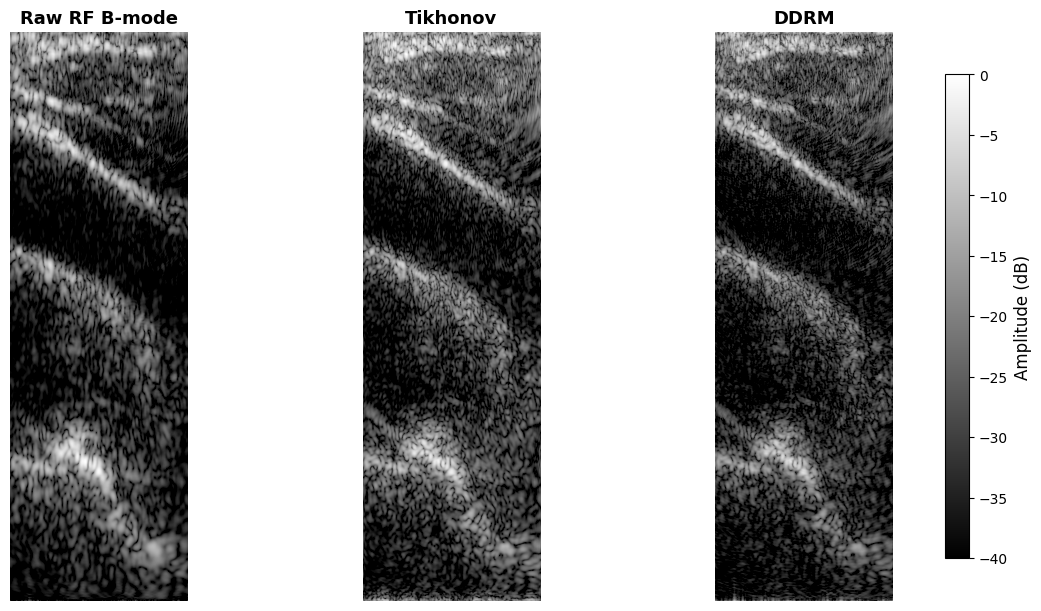

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import hilbert

# ------------------------------
# Load raw RF, Tikhonov, DDRM
# ------------------------------
rf = loadmat('exp/datasets/Besson_Data/rf_image_invivo.mat')['rf_image']
rf = rf.astype(float)
rf /= np.max(np.abs(rf))

VivoTK = loadmat('exp/datasets/Besson_Data/Besson_Tikhonov.mat')['VivoTK']
VivoTK = VivoTK.astype(float)
VivoTK /= np.max(np.abs(VivoTK))

ddrm = loadmat('exp/datasets/Besson_Data/ddrm_result.mat')['rf_reconstructed']
ddrm = ddrm.astype(float)
ddrm /= np.max(np.abs(ddrm))

# ------------------------------
# Envelope + Log Compression
# ------------------------------
def envelope_bmode(x):
    env = np.abs(hilbert(x, axis=0))
    env /= (env.max() + 1e-12)
    return 20 * np.log10(env + np.finfo(float).eps)

bmode_raw  = envelope_bmode(rf)
bmode_tikh = envelope_bmode(VivoTK)
bmode_ddrm = envelope_bmode(ddrm)

# ------------------------------
# Visualization: side by side
# ------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12,6), constrained_layout=True)
titles = ['Raw RF B-mode', 'Tikhonov', 'DDRM']
for ax, im, title in zip(axes, [bmode_raw, bmode_tikh, bmode_ddrm], titles):
    imh = ax.imshow(im, cmap='gray', vmin=-40, vmax=0, origin='upper', aspect='equal')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.axis('off')

cbar = fig.colorbar(imh, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label('Amplitude (dB)', fontsize=12)

plt.show()
